This week I wanted to write an article about the simulation of large systems by means of changing the domain, but unfortunately I didn't finish in time. However, in order to keep my self-imposed weekly rotation, I quickly improvised a small addition to last week's article.

In [4]:
import numpy as np
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
plt.rcParams["font.size"] = 12
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

[Last time][last] we discussed how to construct a non-local fairly accurate
impulse operator using the Fast Fourier Transform.
However, the momentum operator in position space is actually just a scaled derivative. 
So here we will take a look of how to define a spatial derivative using the 
Fourier transform.

[last]: https://znswanderer.github.io/physics/Efficiancy/

The [Fourier transform][fourier] of a function $f(x)$ is given as:

$$
\tilde f(k) = \int_{-\infty}^{\infty} f(x) e^{-2 \pi i x k} dx
$$

and the inverse transform is

$$
f(x) = \int_{-\infty}^{\infty} \tilde f(k) e^{2 \pi i x k} dk \, .
$$

[fourier]: https://en.wikipedia.org/wiki/Fourier_transform

Thus, the first derivative with respect to $x$ can be given by

$$
\frac{d}{dx} f(x) = \int_{-\infty}^{\infty} 2 \pi i k \tilde f(k) e^{2 \pi i x k} dk
$$

and such be understood as multiplication of the Fourier transform by $2 \pi i k$.

We can now express this in discrete periodic space as a linear operator in Python
and make use of the Fast Fourier Transform (FFT) module of `numpy`:

In [6]:
class FFTD1(linalg.LinearOperator):
    def __init__(self, N, length=1):
        super().__init__(dtype='complex128', shape=(N, N))
        self.k_vec = np.fft.fftfreq(N, 1/N) * 2 * np.pi * 1j / length
        
    def _matvec(self, v):
        v_fft = np.fft.fft(v)
        return np.fft.ifft(self.k_vec * v_fft)

Here `length` indicates the size of the periodic space and `N` the number of sampling points 
for the discretization. The use of the `linalg.LinearOperator` has also been
covered in the [last blog post][last_bp].

[last_bp]: https://znswanderer.github.io/physics/Efficiancy/

This derivative operator works only for smooth periodic functions, 
e.g. the smooth sine function with a suitable period:

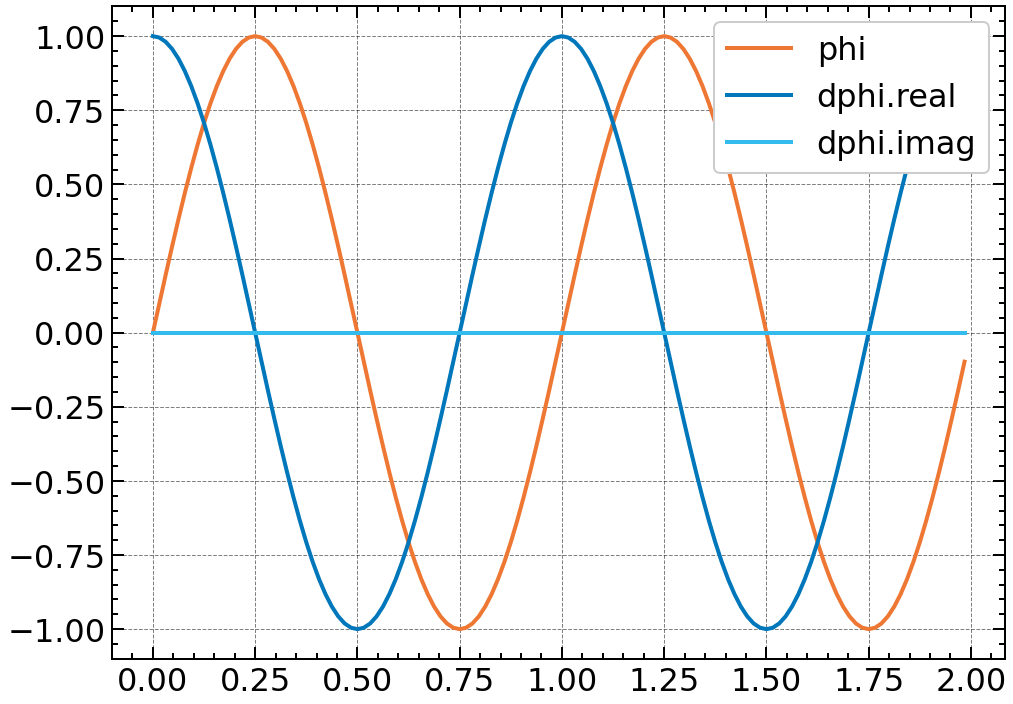

In [10]:
n = 1
N = 128   # for FFT always choose powers of 2 for the sampling points
x = np.linspace(0, 2, N, endpoint=False)
phi = np.sin(n * x * 2 * np.pi) 
D1_fft = FFTD1(N, 2)
d_phi = D1_fft @ phi

plt.figure(figsize=(8,6))
plt.plot(x, phi, label="phi")
plt.plot(x, d_phi.real / (2 * np.pi * n), label="dphi.real")
plt.plot(x, d_phi.imag / (2 * np.pi * n), label="dphi.imag")
plt.legend();

You can see very nicely that the `FFTD1` operator really reproduces the $\cos$-function as a derivative of the
$\sin$-function and does not return any imaginary parts.

But if we take a simple linear function, like $\varphi(x) = x$, it is no longer periodic and 
the derivation via FFT does not work anymore:

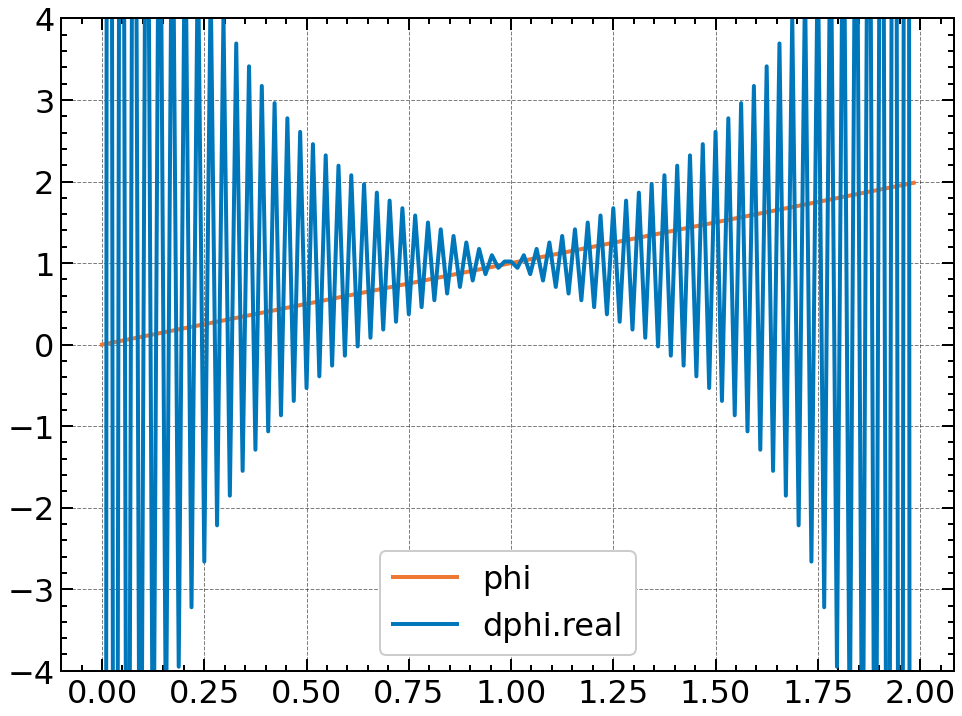

In [11]:
phi = x
d_phi = D1_fft @ phi

plt.figure(figsize=(8,6))
plt.plot(x, phi, label="phi")
plt.plot(x, d_phi.real, label="dphi.real")
plt.ylim(-4, 4)
plt.legend();

This is of course understandable, since $\varphi(x) = x$ is not periodic in $x \in [0, 2]$.
But even simple periodicity is not enough, as the following example shows:

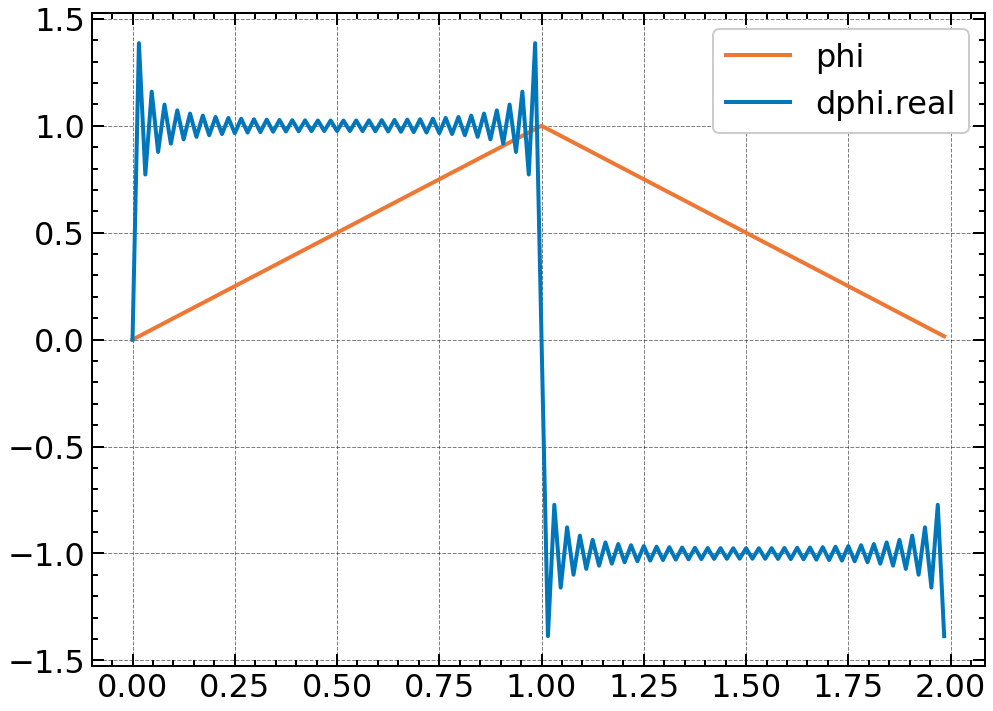

In [12]:
phi = 1 - np.abs(x - 1)
d_phi = D1_fft @ phi

plt.figure(figsize=(8,6))
plt.plot(x, phi, label="phi")
plt.plot(x, d_phi.real, label="dphi.real")
plt.legend();

Here the function is periodic, but not smooth, i.e. the first derivative has discontinuities
at $x=0$ and $x=1$.

The values of the "derivative" now oscillate on average around the correct values of $1$ and $-1$, 
but the effects of the discontinuity in the first derivative can be clearly seen. 
This behavior is known as the [Gibbs phenomenon][beegees].

[beegees]: https://en.wikipedia.org/wiki/Gibbs_phenomenon

I will leave it at that for this week. Next week I'm sure there will be more.